In [ ]:
#!pip install ipywidgets~=7.0
#!pip install jupyter_contrib_nbextensions
#!pip install qrgrid
#!pip install pingouin
import pygwalker as pyg
import pytz
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np 
import seaborn as sns
import pingouin as pg
from datetime import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import linear_model



In [2]:
%matplotlib inline
path = r"C:\Users\marce\OneDrive\Área de Trabalho\Desafio FieldPro"
df1 = pd.read_csv(path + '\Estacao_Convencional.csv')   #Brasilia
df2 = pd.read_csv(path + '\Sensor_FieldPRO.csv')        #UTC

df2 = df2.rename(columns={"Datetime – utc": "data"})

df1['data'] = pd.to_datetime(df1['data']+' '+df1['Hora (Brasília)'],format = '%Y-%m-%d %H:%M:%S%z').dt.tz_localize("Brazil/East")
df2['data'] = pd.to_datetime(df2['data'],format = '%Y-%m-%d %H:%M:%S%z').dt.tz_convert("Brazil/East")
df = df1.merge(df2).drop(["Hora (Brasília)"],axis = 1)   
#pytz.all_timezones

In [3]:
df

,data,chuva,air_humidity_100,air_temperature_100,atm_pressure_main,num_of_resets,piezo_charge,piezo_temperature
0,2020-09-30 20:00:00-03:00,0.0,38.0,31.366,9412,0,45123,30
1,2020-09-30 21:00:00-03:00,0.0,NaN,NaN,9412,0,45025,31
2,2020-09-30 22:00:00-03:00,0.0,39.0,31.366,9419,0,44923,31
3,2020-09-30 23:00:00-03:00,0.0,39.0,31.322,9419,0,44825,31
4,2020-10-01 00:00:00-03:00,0.0,38.0,31.240,9416,0,44728,31
...,...,...,...,...,...,...,...,...
1526,2020-12-03 19:00:00-03:00,0.0,94.0,20.080,9406,3,35007,19
1527,2020-12-03 20:00:00-03:00,0.0,97.0,19.440,9415,3,34948,19
1528,2020-12-03 21:00:00-03:00,0.0,97.0,18.980,9428,3,34889,19
1529,2020-12-03 22:00:00-03:00,0.0,97.0,18.620,9441,3,34833,17


In [4]:
%matplotlib inline
df_xls = df
df_xls['data'] = pd.to_datetime(df_xls['data'].dt.tz_localize(None),format = '%Y-%m-%d %H:%M:%S')
df.to_excel(path + "\dfFieldPro.xlsx",
             sheet_name='Sheet_name_1')  

In [5]:
print(df.describe())

             chuva  air_humidity_100  air_temperature_100  atm_pressure_main  \
count  1531.000000       1525.000000          1525.000000        1531.000000   
mean      0.093011         58.704262            24.776121        9432.415415   
std       0.827673         21.933831             6.305237          27.286974   
min       0.000000         13.000000            12.360000        9350.000000   
25%       0.000000         40.000000            19.900000        9415.000000   
50%       0.000000         59.000000            23.120000        9433.000000   
75%       0.000000         78.000000            29.720000        9451.000000   
max      16.800000         99.000000            42.664000        9507.000000   

       num_of_resets  piezo_charge  piezo_temperature  
count    1531.000000   1531.000000        1531.000000  
mean        1.489223  44189.235140          25.045722  
std         1.043051  12626.514389           8.517141  
min         0.000000  16950.000000          11.000000  

<function matplotlib.pyplot.show(close=None, block=None)>

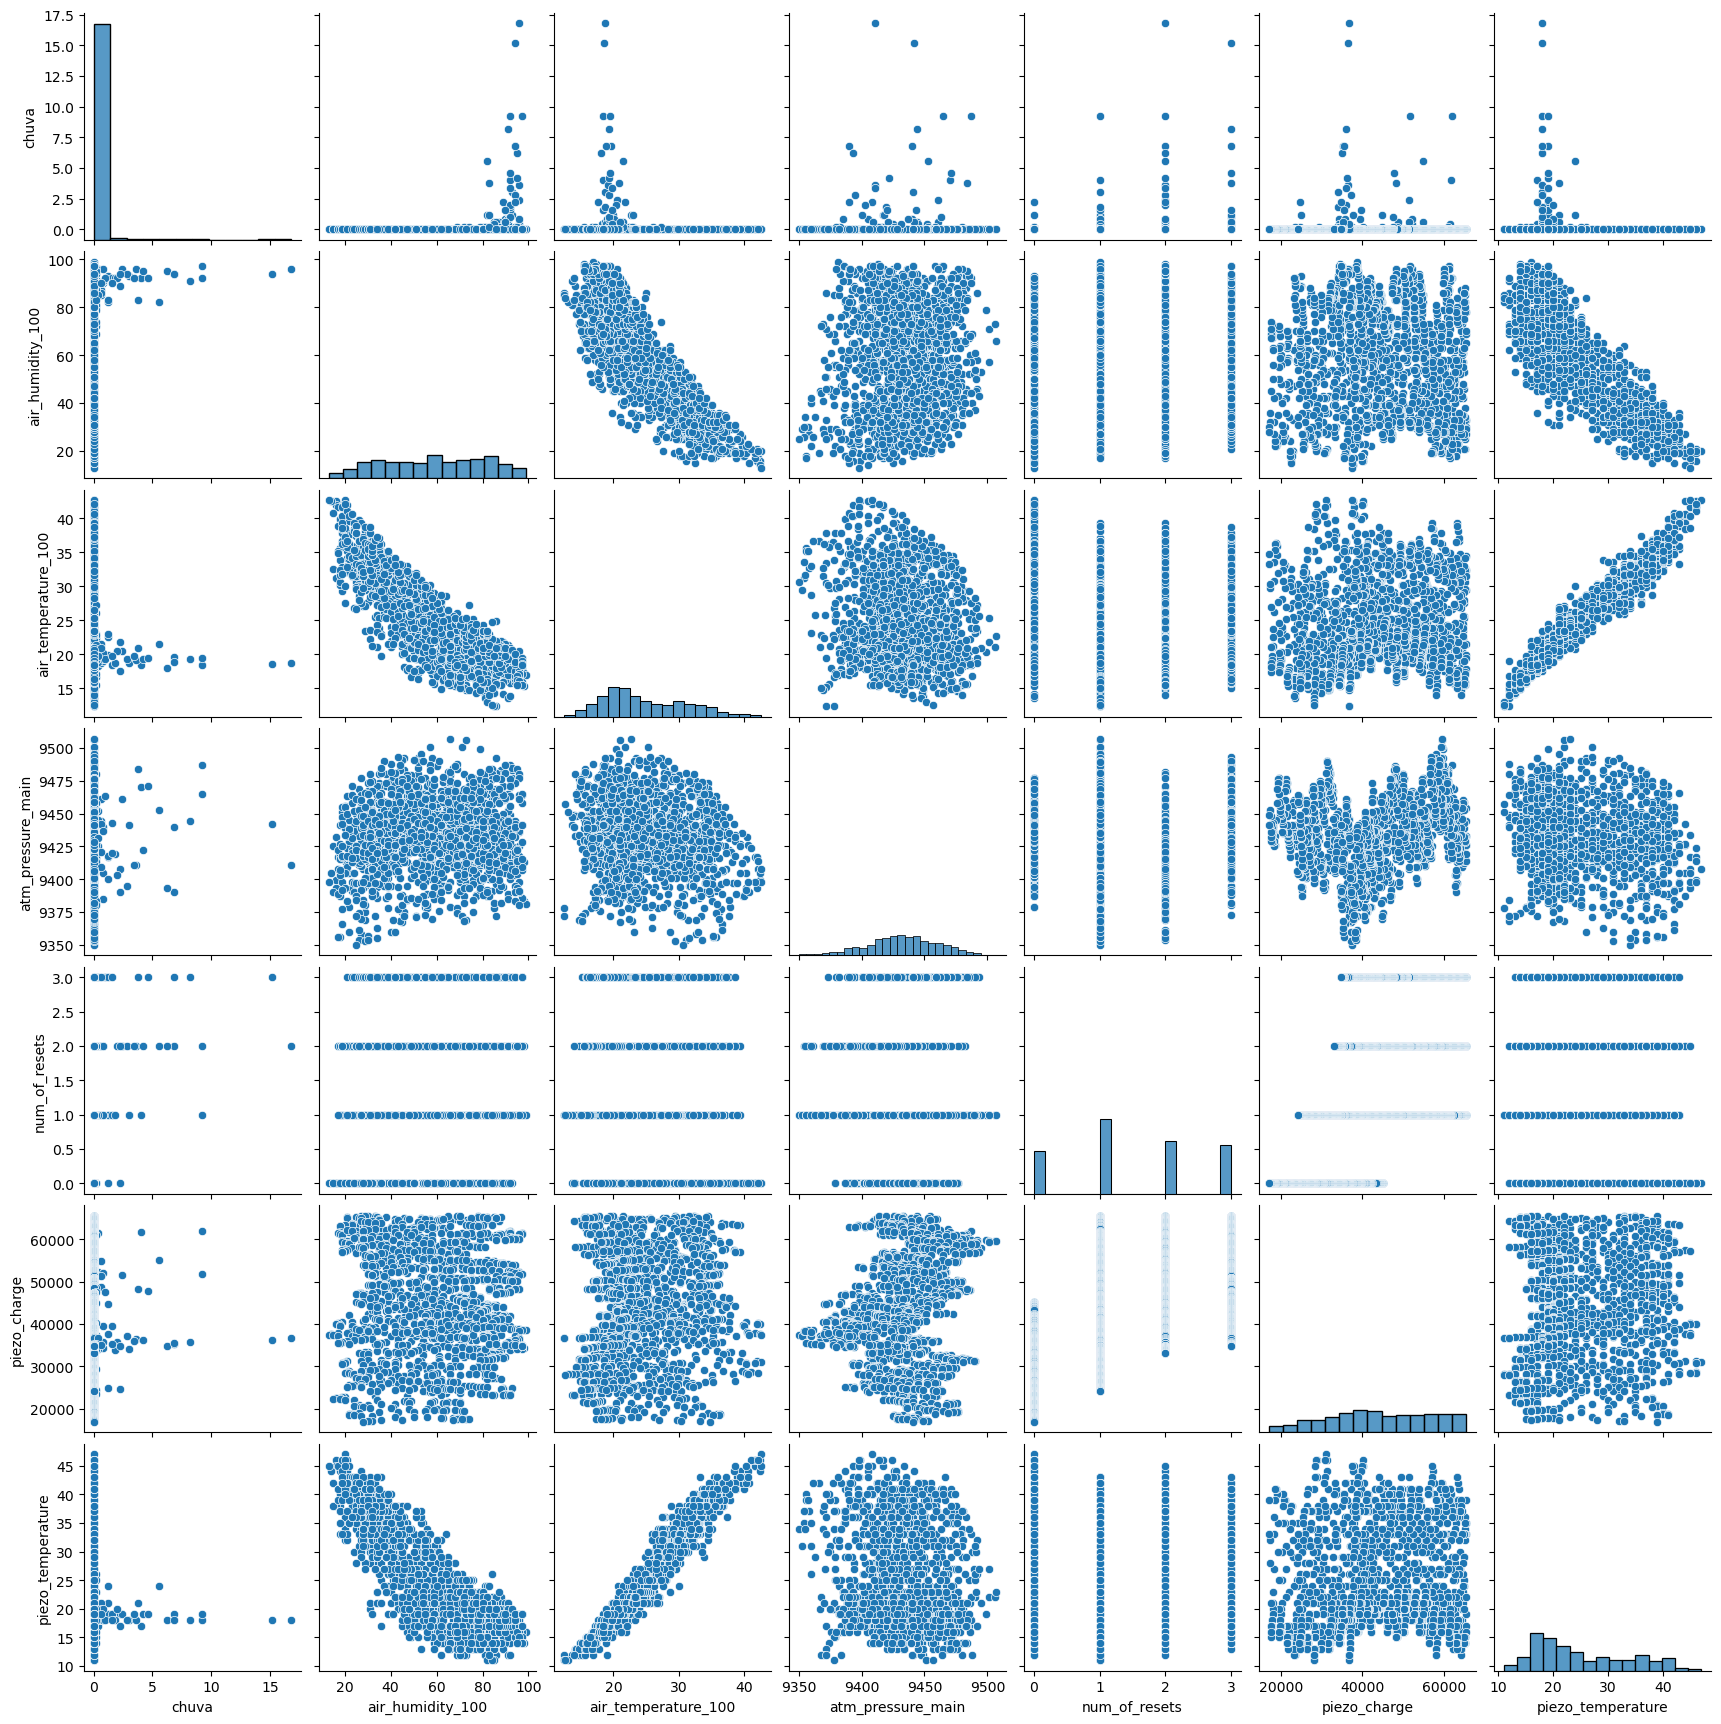

In [6]:
figsize=(15,10)
sns.pairplot(df)
plt.show

array([[<Axes: title={'center': 'chuva'}>,
        <Axes: title={'center': 'air_humidity_100'}>,
        <Axes: title={'center': 'air_temperature_100'}>],
       [<Axes: title={'center': 'atm_pressure_main'}>,
        <Axes: title={'center': 'num_of_resets'}>,
        <Axes: title={'center': 'piezo_charge'}>],
       [<Axes: title={'center': 'piezo_temperature'}>, <Axes: >,
        <Axes: >]], dtype=object)

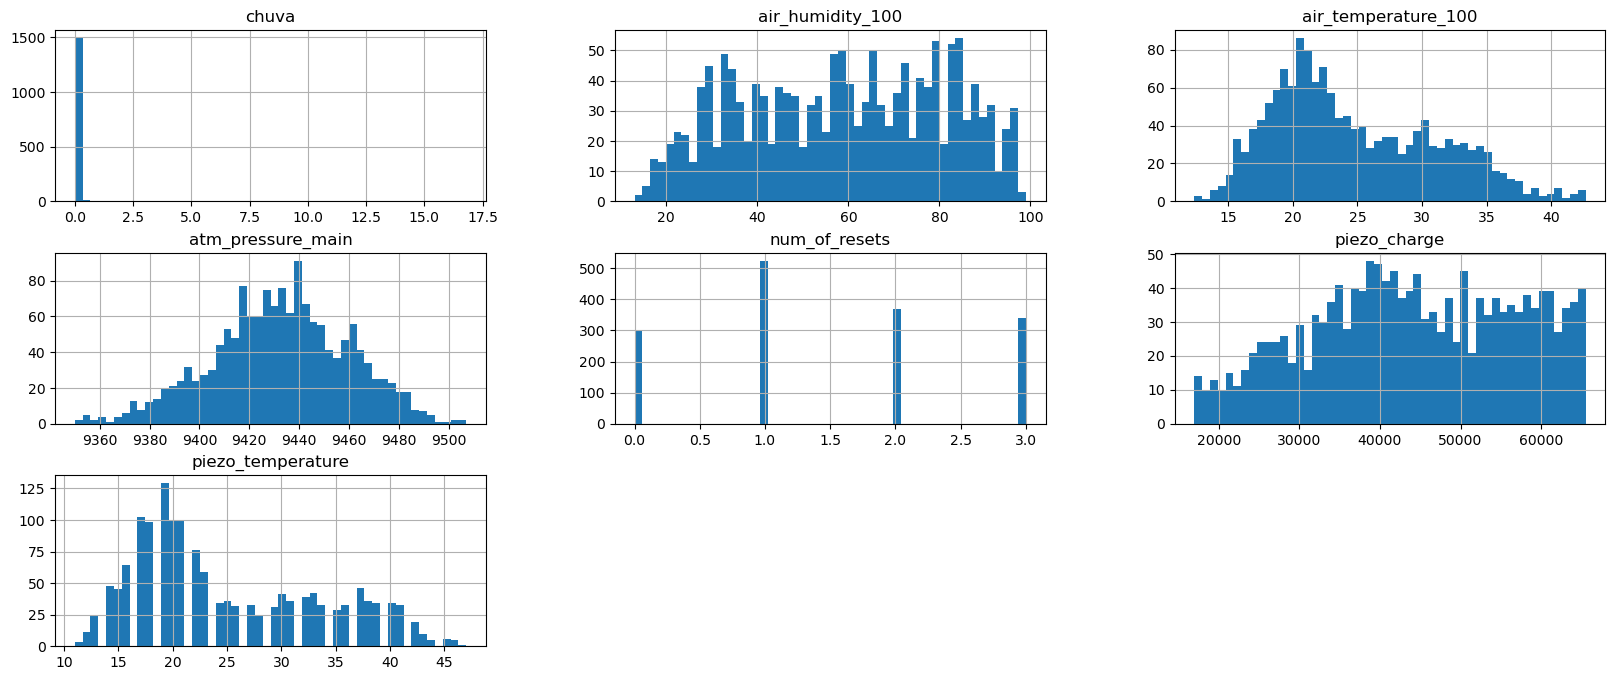

In [7]:
df[['chuva', 'air_humidity_100', 'air_temperature_100', 'atm_pressure_main', 'num_of_resets', 
    'piezo_charge', 'piezo_temperature']].hist(figsize=(20,8), bins=50)

<Axes: >

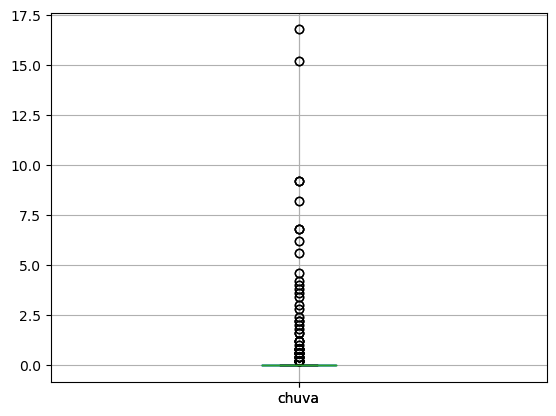

In [8]:
%matplotlib inline
df.boxplot(['chuva'])

Q1 = df['chuva'].quantile(0.25)
Q3 = df['chuva'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 

#Necessário entendimento vertical sobre outliers para aplicação do melhor critério
#filter = (df['chuva'] >= Q1 - 1.5 * IQR) & (df['chuva'] <= Q3 + 1.5 *IQR)
#df = df.loc[filter]  

#Depois
df.boxplot(['chuva'])

In [9]:
#Ação e análise alternativas: eliminar dias não chuvosos.
#Mesmo inflado de zeros, dias não chuvosos precisam ser considerados no modelo. Necessário entendimento com especialistas.

filter = (df['chuva'] >= 0.01) 
df = df.loc[filter]  


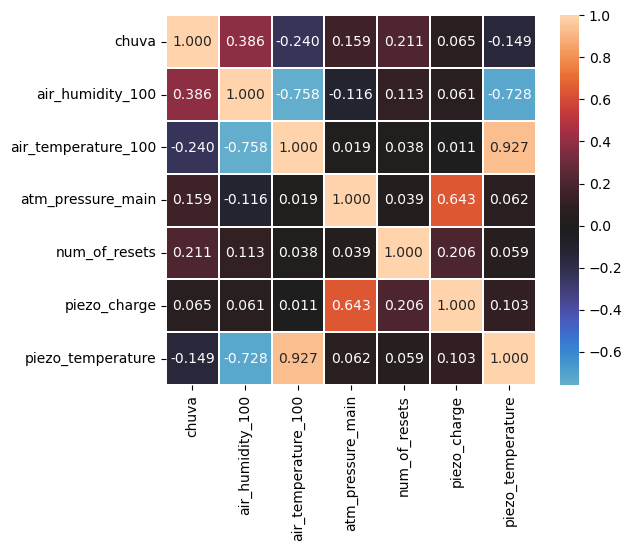

In [10]:
%matplotlib inline

#filter = (df['chuva'] > 0) 
#df = df.loc[filter]  

data_corr = df.loc[:,['chuva', 'air_humidity_100', 'air_temperature_100', 'atm_pressure_main', 'num_of_resets', 'piezo_charge', 'piezo_temperature']]

#data_corr = df.loc[:,['chuva', 'air_humidity_100', 'air_temperature_100', 'piezo_charge', 'piezo_temperature']]

# Create a matrix from the data
matrix = data_corr.corr()

# Plot the correlation matrix
sns.heatmap(
        matrix,
        center=0,
        fmt='.3f',
        square=True,
        annot=True,
        linewidth=.3
    )
%matplotlib inline

O modelo é: Chuva = 1.6129 + 2.4058e-05X
R2:0.004


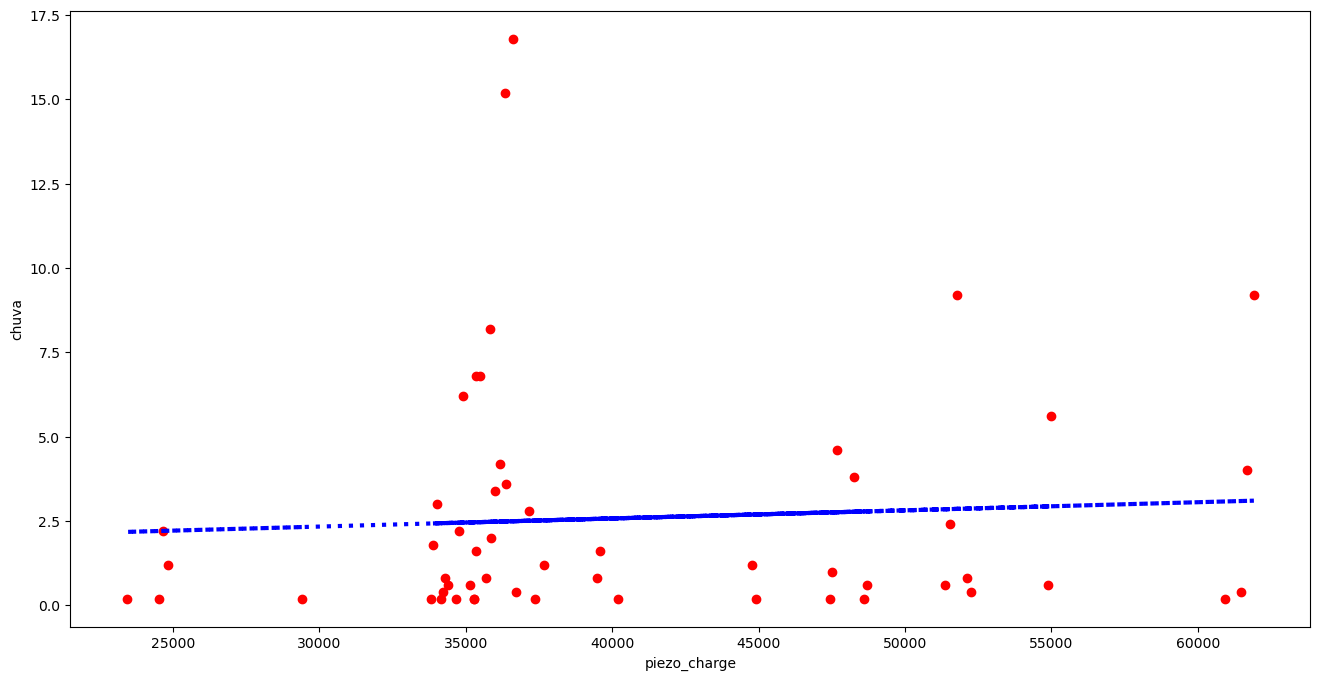

                            OLS Regression Results                            
Dep. Variable:                  chuva   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.015
Method:                 Least Squares   F-statistic:                    0.2274
Date:                Wed, 02 Aug 2023   Prob (F-statistic):              0.635
Time:                        10:05:25   Log-Likelihood:                -147.59
No. Observations:                  55   AIC:                             299.2
Df Residuals:                      53   BIC:                             303.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.6129      2.104      0.767   

In [11]:
Depend = 'chuva'
Independ = 'piezo_charge'

X = df[Independ].values.reshape(-1,1)
y = df[Depend].values.reshape(-1,1)

reg = LinearRegression()
reg.fit(X, y)

r2 = reg.score(X, y)

print("O modelo é: Chuva = {:.5} + {:.5}X".format(reg.intercept_[0], reg.coef_[0][0]))
print("R2:"+str(round(r2,3)))

f_previsaoes = reg.predict(X)

plt.figure(figsize = (16,8))
plt.scatter(
    df[Independ], 
    df[Depend], 
    c='red')

plt.plot(
    df[Independ],
    f_previsaoes,
    c='blue',
    linewidth=3,
    linestyle=':'
)

plt.xlabel(Independ)
plt.ylabel(Depend)
plt.show()

X = df[Independ]
y = df[Depend]
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())


In [12]:
Depend = 'chuva'
X = df.drop(['data','chuva'], axis=1)
y = df[Depend]

modelo = LinearRegression()
modelo.fit(X,y)
LinearRegression()

modelo.score(X,y)
modelo.intercept_
modelo.coef_

array([ 3.47407890e-01, -7.53368010e-01,  5.22384538e-02,  6.54617159e-01,
       -1.21524293e-04,  1.10109314e+00])

In [13]:
X = df.drop(['data','chuva'], axis=1)
y = df[Depend]

lm = pg.linear_regression(X, y, as_dataframe=True)
lm.round(2)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,-523.24,205.44,-2.55,0.01,0.31,0.23,-936.31,-110.17
1,air_humidity_100,0.35,0.11,3.10,0.00,0.31,0.23,0.12,0.57
2,air_temperature_100,-0.75,0.61,-1.24,0.22,0.31,0.23,-1.98,0.47
3,atm_pressure_main,0.05,0.02,2.43,0.02,0.31,0.23,0.01,0.10
4,num_of_resets,0.65,0.48,1.35,0.18,0.31,0.23,-0.32,1.63
5,piezo_charge,-0.00,0.00,-1.94,0.06,0.31,0.23,-0.00,0.00
6,piezo_temperature,1.10,0.53,2.07,0.04,0.31,0.23,0.03,2.17


In [14]:
lm1 = pg.linear_regression(X, y, as_dataframe=False)

print(lm1['df_model']) #graus de liberdade do modelo
print(lm1['df_resid']) #graus de liberdade dos resíduos

6
48


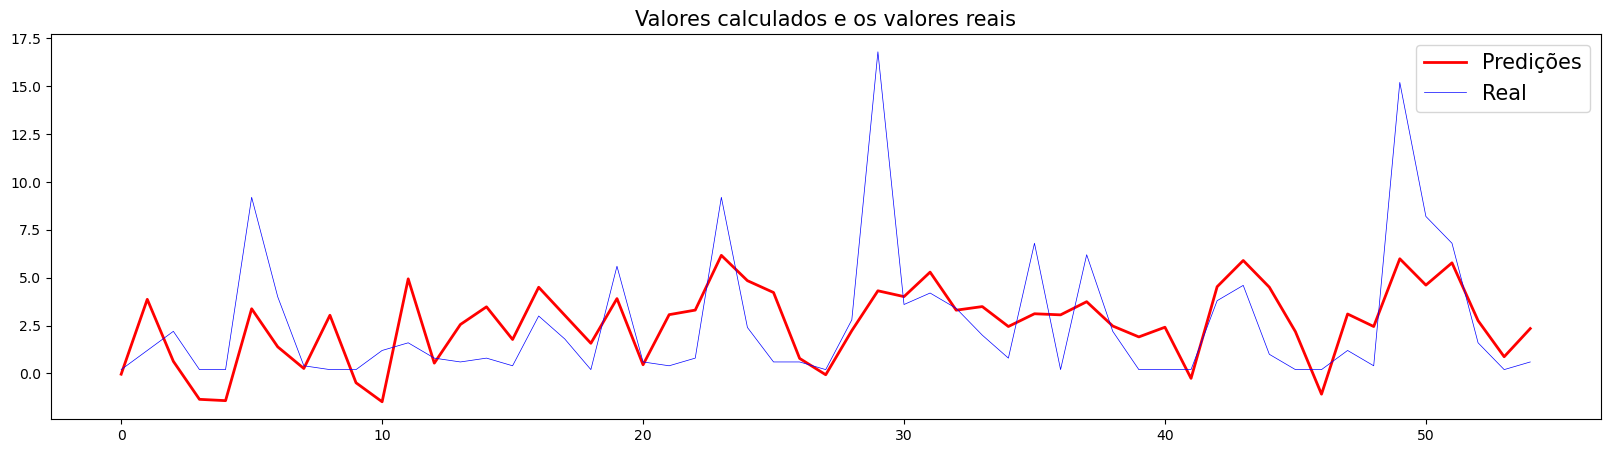

In [15]:
x = lm1['pred'].tolist()
Y = y.tolist()
%matplotlib inline
plt.figure(figsize=(20,5))
plt.plot(x, linewidth=2, color='r')
plt.plot(Y, linewidth=0.5,color='b')
plt.title('Valores calculados e os valores reais',size=15)
plt.legend(['Predições','Real'],fontsize=15)
plt.show()